In [82]:
import argparse
import os
from kabuki.analyze import gelman_rubin
import pandas
import hddm
import numpy as np

path = '/home/gdholla1/projects/bias/data/hddm_fits'

def get_model(model):
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')

    # Prepare data
    data = df[['cue_validity', 'rt', 'correct', 'difficulty', 'subj_idx']]
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    regs, free_pars = model.split('_')

    if regs == 'drift':
        z_reg = {'model': 'z ~ 0', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}
    elif regs == 'startpoint':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)', 'link_func': lambda x: x}
    elif regs == 'both':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}

    reg_descr = [z_reg, v_reg]

    if free_pars == 'sv':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])
    elif free_pars == 'sz':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sz'), bias=True, group_only_regressors=False, group_only_nodes=['sz'])
    elif free_pars == 'svsz':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz'])
    elif free_pars == 'all':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
    elif free_pars == 'none':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, bias=True, group_only_regressors=False)

    return hddm_model

In [83]:
import glob
import re

import pickle as pkl

In [84]:
# models = ['drift_all', 'drift_sv', 'drift_sz', 'drift_svsz',
#           'startpoint_all', 'startpoint_sv', 'startpoint_sz', 'startpoint_svsz',
#           'both_all', 'both_sv', 'both_sz', 'both_svsz']

# models = ['drift_sv', 'drift_sz', 'drift_svsz',
#           'startpoint_sv', 'startpoint_sz', 'startpoint_svsz',
#           'both_sz', 'both_svsz']


models = ['drift_sv', 'startpoint_sv', 'both_sv']

models = ['drift_sv', 'startpoint_sv', 'both_sv']

models = ['both_all', 'startpoint_all', 'startpoint_sv', 'both_sv', 'both_svsz', 'startpoint_svsz']
models = ['both_all', 'drift_all', 'startpoint_sv', 'both_sv', 'both_svsz', 'startpoint_svsz', 'drift_none', 'startpoint_none', 'both_none']

r = []
dics = []

for model in models:
    print model
    hddm_model = get_model(model)
    reg = re.compile('.*/traces_{model}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_model.load_db(fns[0], db='pickle')

    for fn in fns[1:]:
        traces = pkl.load(open(fn))    
        for node in hddm_model.get_stochastics().node:
            node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])
            
    dics.append({'model':model, 'dic':hddm_model.dic})

    traces = hddm_model.get_traces()
    for subj_idx in np.arange(1, 20):
        r.append({'subj_idx':subj_idx, 'model':model})
        
        if 'z_cue_coding' in traces.columns:
            r[-1].update({'z_cue_coding':traces['z_cue_coding_subj.%d' % subj_idx].mean()})
            
        if 'v_cue_coding' in traces.columns:
            r[-1].update({'v_cue_coding':traces['v_cue_coding_subj.%d' % subj_idx].mean()})            

both_all


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
drift_all
Adding these covariates:
[]
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
startpoint_sv
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
both_sv
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
both_svsz
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
startpoint_svsz
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
drift_none
Adding these covariates:
[]
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
startpoint_none
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(diffi

In [85]:
pandas.DataFrame(dics).sort('dic')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dic,model
0,5437.414338,both_all
1,5501.816389,drift_all
4,8823.082472,both_svsz
3,8824.523659,both_sv
8,8903.094529,both_none
6,8965.831529,drift_none
5,9027.659846,startpoint_svsz
2,9029.506058,startpoint_sv
7,9097.423342,startpoint_none


In [86]:
tmp = pandas.DataFrame(r).pivot_table(index='subj_idx', columns='model')

In [87]:
tmp.corr()

v_cue_coding                                \
model                            both_all both_none   both_sv both_svsz   
             model                                                        
v_cue_coding both_all            1.000000  0.915932  0.910173  0.909860   
             both_none           0.915932  1.000000  0.999422  0.999350   
             both_sv             0.910173  0.999422  1.000000  0.999997   
             both_svsz           0.909860  0.999350  0.999997  1.000000   
             drift_all           0.745092  0.927892  0.930670  0.930744   
             drift_none          0.752876  0.932314  0.935273  0.935356   
             startpoint_none          NaN       NaN       NaN       NaN   
             startpoint_sv            NaN       NaN       NaN       NaN   
             startpoint_svsz          NaN       NaN       NaN       NaN   
z_cue_coding both_all            0.066198  0.421532  0.433062  0.433620   
             both_none          -0.618727 -0.394561 -0.385116 -0.384679   
             both_sv            -0.662418 -0.450418 -0.442035 -0.441641   
             both_svsz          -0.660628 -0.448168 -0.439835 -0.439446   
             drift_all                NaN       NaN       NaN       NaN   
             drift_none               NaN       NaN       NaN       NaN   
             startpoint_none     0.272197  0.535325  0.544399  0.544857   
             startpoint_sv       0.203328  0.474565  0.484000  0.484488   
             startpoint_svsz     0.200956  0.472328  0.481760  0.482248   

                                                                   \
model                        drift_all drift_none startpoint_none   
             model                                                  
v_cue_coding both_all         0.745092   0.752876             NaN   
             both_none        0.927892   0.932314             NaN   
             both_sv          0.930670   0.935273             NaN   
             both_svsz        0.930744   0.935356             NaN   
             drift_all        1.000000   0.999231             NaN   
             drift_none       0.999231   1.000000             NaN   
             startpoint_none       NaN        NaN             NaN   
             startpoint_sv         NaN        NaN             NaN   
             startpoint_svsz       NaN        NaN             NaN   
z_cue_coding both_all         0.711801   0.702796             NaN   
             both_none       -0.026360  -0.036986             NaN   
             both_sv         -0.087877  -0.099055             NaN   
             both_svsz       -0.085371  -0.096567             NaN   
             drift_all             NaN        NaN             NaN   
             drift_none            NaN        NaN             NaN   
             startpoint_none  0.805442   0.800605             NaN   
             startpoint_sv    0.762409   0.756477             NaN   
             startpoint_svsz  0.760758   0.754794             NaN   

                                                           z_cue_coding  \
model                        startpoint_sv startpoint_svsz     both_all   
             model                                                        
v_cue_coding both_all                  NaN             NaN     0.066198   
             both_none                 NaN             NaN     0.421532   
             both_sv                   NaN             NaN     0.433062   
             both_svsz                 NaN             NaN     0.433620   
             drift_all                 NaN             NaN     0.711801   
             drift_none                NaN             NaN     0.702796   
             startpoint_none           NaN             NaN          NaN   
             startpoint_sv             NaN             NaN          NaN   
             startpoint_svsz           NaN             NaN          NaN   
z_cue_coding both_all                  NaN             NaN     1.000000   
             both_none      

In [88]:
sns.set_context('poster')
sns.set_style('whitegrid')

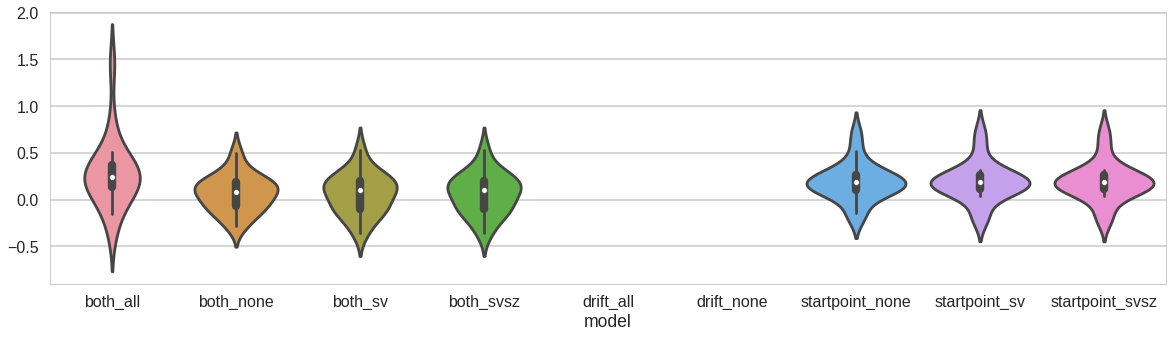

In [89]:
sns.violinplot(tmp['z_cue_coding'], aspect=5)
plt.gcf().set_size_inches(20, 5)

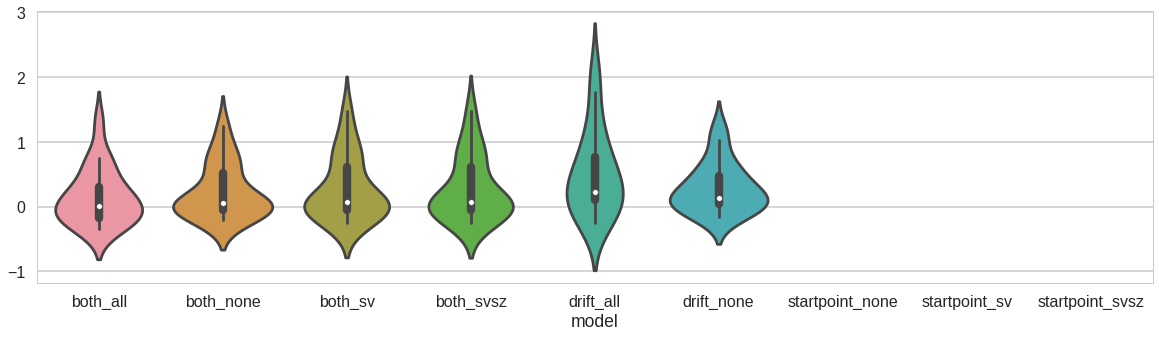

In [90]:
sns.violinplot(tmp['v_cue_coding'], aspect=5)
plt.gcf().set_size_inches(20, 5)

In [65]:
model = 'both_all'

hddm_model = get_model(model)
reg = re.compile('.*/traces_{model}_[0-9]+.pkl'.format(**locals()))
fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_*.pkl'.format(**locals())) if reg.match(fn)]

hddm_model.load_db(fns[0], db='pickle')

for fn in fns[1:]:
    traces = pkl.load(open(fn))    
    for node in hddm_model.get_stochastics().node:
        node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


ValueError: insecure string pickle

In [62]:
traces = hddm_model.get_traces()

In [63]:
traces.shape

(9000, 129)

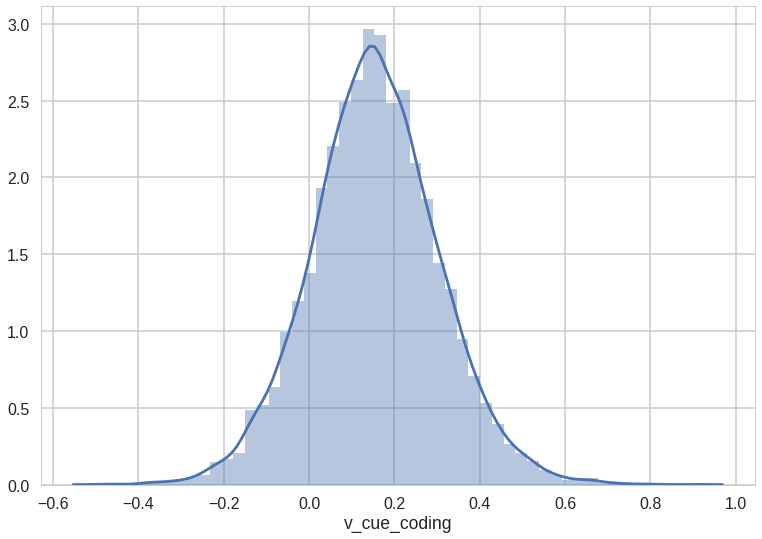

In [56]:
sns.distplot(traces['v_cue_coding'])